# Detección de anomalías y técnicas de agrupamiento

### Objetivos 

Mediante este trabajo se pretende que poner en práctica la aplicación de los algoritmos de detección de anomalías u outliers y las técnicas de agrupamiento. El objetivo es detectar anomalías, generar y analizar agrupaciones aplicando algoritmos de aprendizaje máquina, con el fin de elegir el mejor método para el conjunto de datos dado. Debe detallar los pasos que hay que realizar para la detección automática de valores inusuales y, por otro lado, analizar los clúster o grupos resultado de aplicar un algoritmo de agrupamiento.


#### Sobre los datos:

Se procesaron automáticamente 2126 cardiotocogramas (CTGs) fetales y se midieron las características diagnósticas respectivas. Los CTGs también fueron clasificados por tres obstetras expertos y se asignó una etiqueta de clasificación de consenso a cada uno de ellos. La clasificación fue tanto con respecto a un patrón morfológico (A, B, C...) como a un estado fetal (N, S, P). Por lo tanto, el conjunto de datos se puede utilizar tanto para experimentos de 10 clases como de 3 clases.

* Fecha: de la examinación
* b: instante de inicio
* e: instante de finalización
* LBE: valor basal (experto médico)
* LB: valor basal (SisPorto)
* AC: aceleraciones (SisPorto)
* FM: movimientos fetales (SisPorto)
* UC: contracciones uterinas (SisPorto)
* ASTV: porcentaje de tiempo con variabilidad a corto plazo anormal (SisPorto)
* mSTV: valor medio de la variabilidad a corto plazo (SisPorto)
* ALTV: porcentaje de tiempo con variabilidad a largo plazo anormal (SisPorto)
* mLTV: valor medio de la variabilidad a largo plazo (SisPorto)
* DL: deceleraciones leves
* DS: deceleraciones severas
* DP: deceleraciones prolongadas
* DR: deceleraciones repetitivas
* Width: ancho del histograma
* Min: frecuencia baja del histograma
* Max: frecuencia alta del histograma
* Nmax: número de picos del histograma
* Nzeros: número de ceros del histograma
* Mode: modo del histograma
* Mean: media del histograma
* Median: mediana del histograma
* Variance: varianza del histograma
* Tendency: tendencia del histograma: -1=asimétrico izquierdo; 0=simétrico; 1=asimétrico derecho
* A: sueño tranquilo
* B: sueño REM
* C: vigilia tranquila
* D: vigilia activa
* AD: patrón acelerativo/decelerativo (situación de estrés)
* DE: patrón decelerativo (estimulación vagal)
* LD: patrón mayormente decelerativo
* FS: patrón plano-sinusoidal (estado patológico)
* SUSP: patrón sospechoso
* CLASS: Código de clase (1 a 10) para clases A a SUSP
* NSP: - Normal=1; Suspect=2; Pathologic=3

In [58]:
import math

# librerias
import numpy as np
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from histograma import histogram_all
from histograma import boxplot_all
from outliers import otliers
from sklearn.cluster import KMeans

In [59]:
# leemos el conjunto de datos
data = pd.read_csv("./Datos/CTG.csv")
data.head(3)

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,5/3/1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0


De inicio es posible ver sin mucho analisis que podemos eliminar columnas que no nos aportan mucha información: 

**Filename, Date y segfile:** Nos muestra la fecha y nombre de los documentos. Esta información son irrelevantes en este analisis de datos.

**b(instante de inicio), e(instante de finalizacion):**: Nos puede mostrar un numero que representar el primer punto en el inicio y final en la grafica del electrocardiograma. Sin embargo al no tener mucha informacion sobre esta variable se descarta.

**A(sueño tranquilo), B(sueño REM), C(Vigilia tranquila), D(vigilia activa):** Estas variables no aportan mucha información ya que es muy poco probable que tener ritmos anormales durante el sueño ya que este suele estar relacionada con el estrés, la ansiedad y otros factores. 

**DR(deceleraciones repetitivas):**  Esta columna esta en ceros.

**NZeros:** Muestra los 0 del electrocardiograma

**E:** No tenemos información al respecto.

In [60]:
#eliminamos columnas innecesarias
data = data.drop(["FileName","Date",'DR',"Nzeros","SegFile",'FM',"b","e","A", "B","C", "D" ,"E","DL"], axis=1)
data.head(3)

,LBE,LB,AC,UC,ASTV,MSTV,ALTV,MLTV,DS,DP,...,Median,Variance,Tendency,AD,DE,LD,FS,SUSP,CLASS,NSP
0,120.0,120.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,...,121.0,73.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,132.0,132.0,4.0,4.0,17.0,2.1,0.0,10.4,0.0,0.0,...,140.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,133.0,133.0,2.0,5.0,16.0,2.1,0.0,13.4,0.0,0.0,...,138.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0


In [61]:
#verificamos datos faltantes
data.isnull().sum()

LBE         3
LB          3
AC          3
UC          2
ASTV        2
MSTV        2
ALTV        2
MLTV        2
DS          1
DP          1
Width       3
Min         3
Max         3
Nmax        3
Mode        3
Mean        3
Median      3
Variance    3
Tendency    3
AD          3
DE          3
LD          3
FS          3
SUSP        3
CLASS       3
NSP         3
dtype: int64

# Tratamiento de mising values
El conjunto de datos presenta valores faltantes distribuidos en todas sus columnas. En 19 de estas columnas, se observan tres datos ausentes, mientras que en las restantes 6, la ausencia es de 2 datos. Las últimas dos variables presentan un solo dato faltante cada una.

Dado que el conjunto de datos consta de 2126 observaciones por variable, la presencia de tres datos faltantes en algunas columnas no representa ni siquiera el 1% del total de datos. Por lo tanto, desde un punto de vista estadístico, el impacto de estos valores faltantes en los análisis posteriores sería insignificante.

Para abordar esta situación, se procederá a eliminar las observaciones con valores faltantes. Esta estrategia se elige debido a la baja proporción de datos perdidos en relación con el tamaño total del conjunto de datos, lo que minimiza el potencial sesgo introducido por su eliminación. Además, eliminar las observaciones con valores faltantes simplificará el análisis posterior y garantizará la integridad de los resultados obtenidos.

In [62]:
#eliminamos los valores faltantes
data = data.dropna()
data.isnull().sum()

LBE         0
LB          0
AC          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DS          0
DP          0
Width       0
Min         0
Max         0
Nmax        0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
AD          0
DE          0
LD          0
FS          0
SUSP        0
CLASS       0
NSP         0
dtype: int64

In [63]:
#De las variables numéricas, hallar datos estadísticos.
data.describe()

,LBE,LB,AC,UC,ASTV,MSTV,ALTV,MLTV,DS,DP,...,Median,Variance,Tendency,AD,DE,LD,FS,SUSP,CLASS,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,133.303857,2.722484,3.659925,46.990122,1.332785,9.84666,8.187629,0.003293,0.126058,...,138.090310,18.808090,0.320320,0.156162,0.118532,0.050329,0.032455,0.092662,4.509878,1.304327
std,9.840844,9.840844,3.560850,2.847094,17.192814,0.883241,18.39688,5.628247,0.057300,0.464361,...,14.466589,28.977636,0.610829,0.363094,0.323314,0.218675,0.177248,0.290027,3.026883,0.614377
min,106.000000,106.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,0.000000,0.000000,...,77.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,126.000000,126.000000,0.000000,1.000000,32.000000,0.700000,0.00000,4.600000,0.000000,0.000000,...,129.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,133.000000,133.000000,1.000000,3.000000,49.000000,1.200000,0.00000,7.400000,0.000000,0.000000,...,139.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
75%,140.000000,140.000000,4.000000,5.000000,61.000000,1.700000,11.00000,10.800000,0.000000,0.000000,...,148.000000,24.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
max,160.000000,160.000000,26.000000,23.000000,87.000000,7.000000,91.00000,50.700000,1.000000,4.000000,...,186.000000,269.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,3.000000


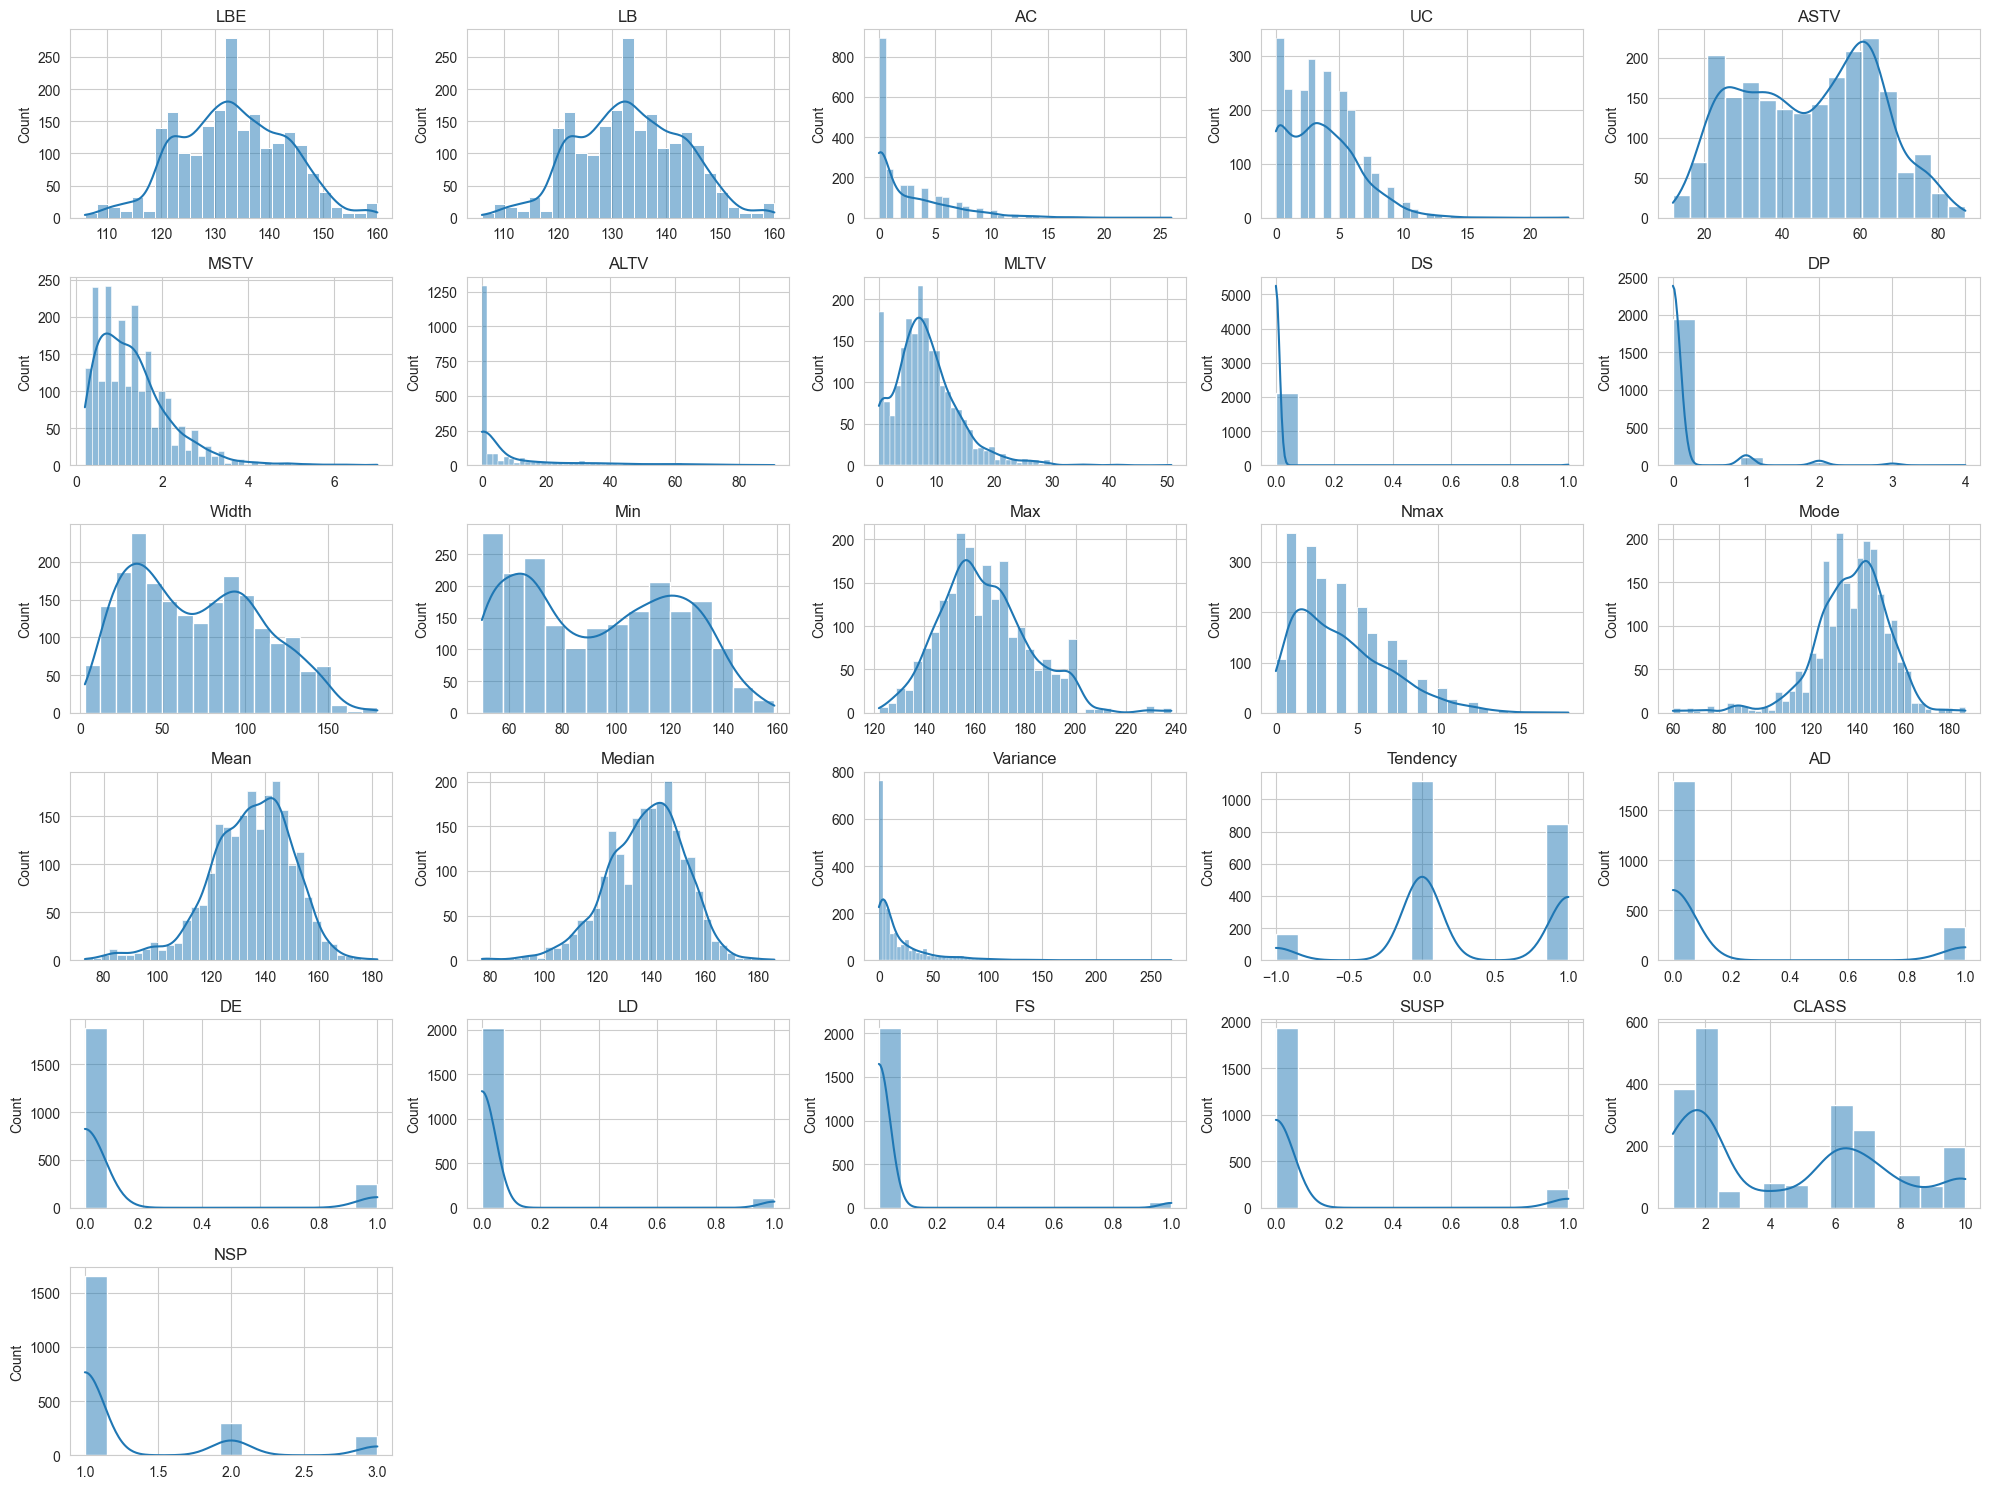

In [64]:
histogram_all(data)

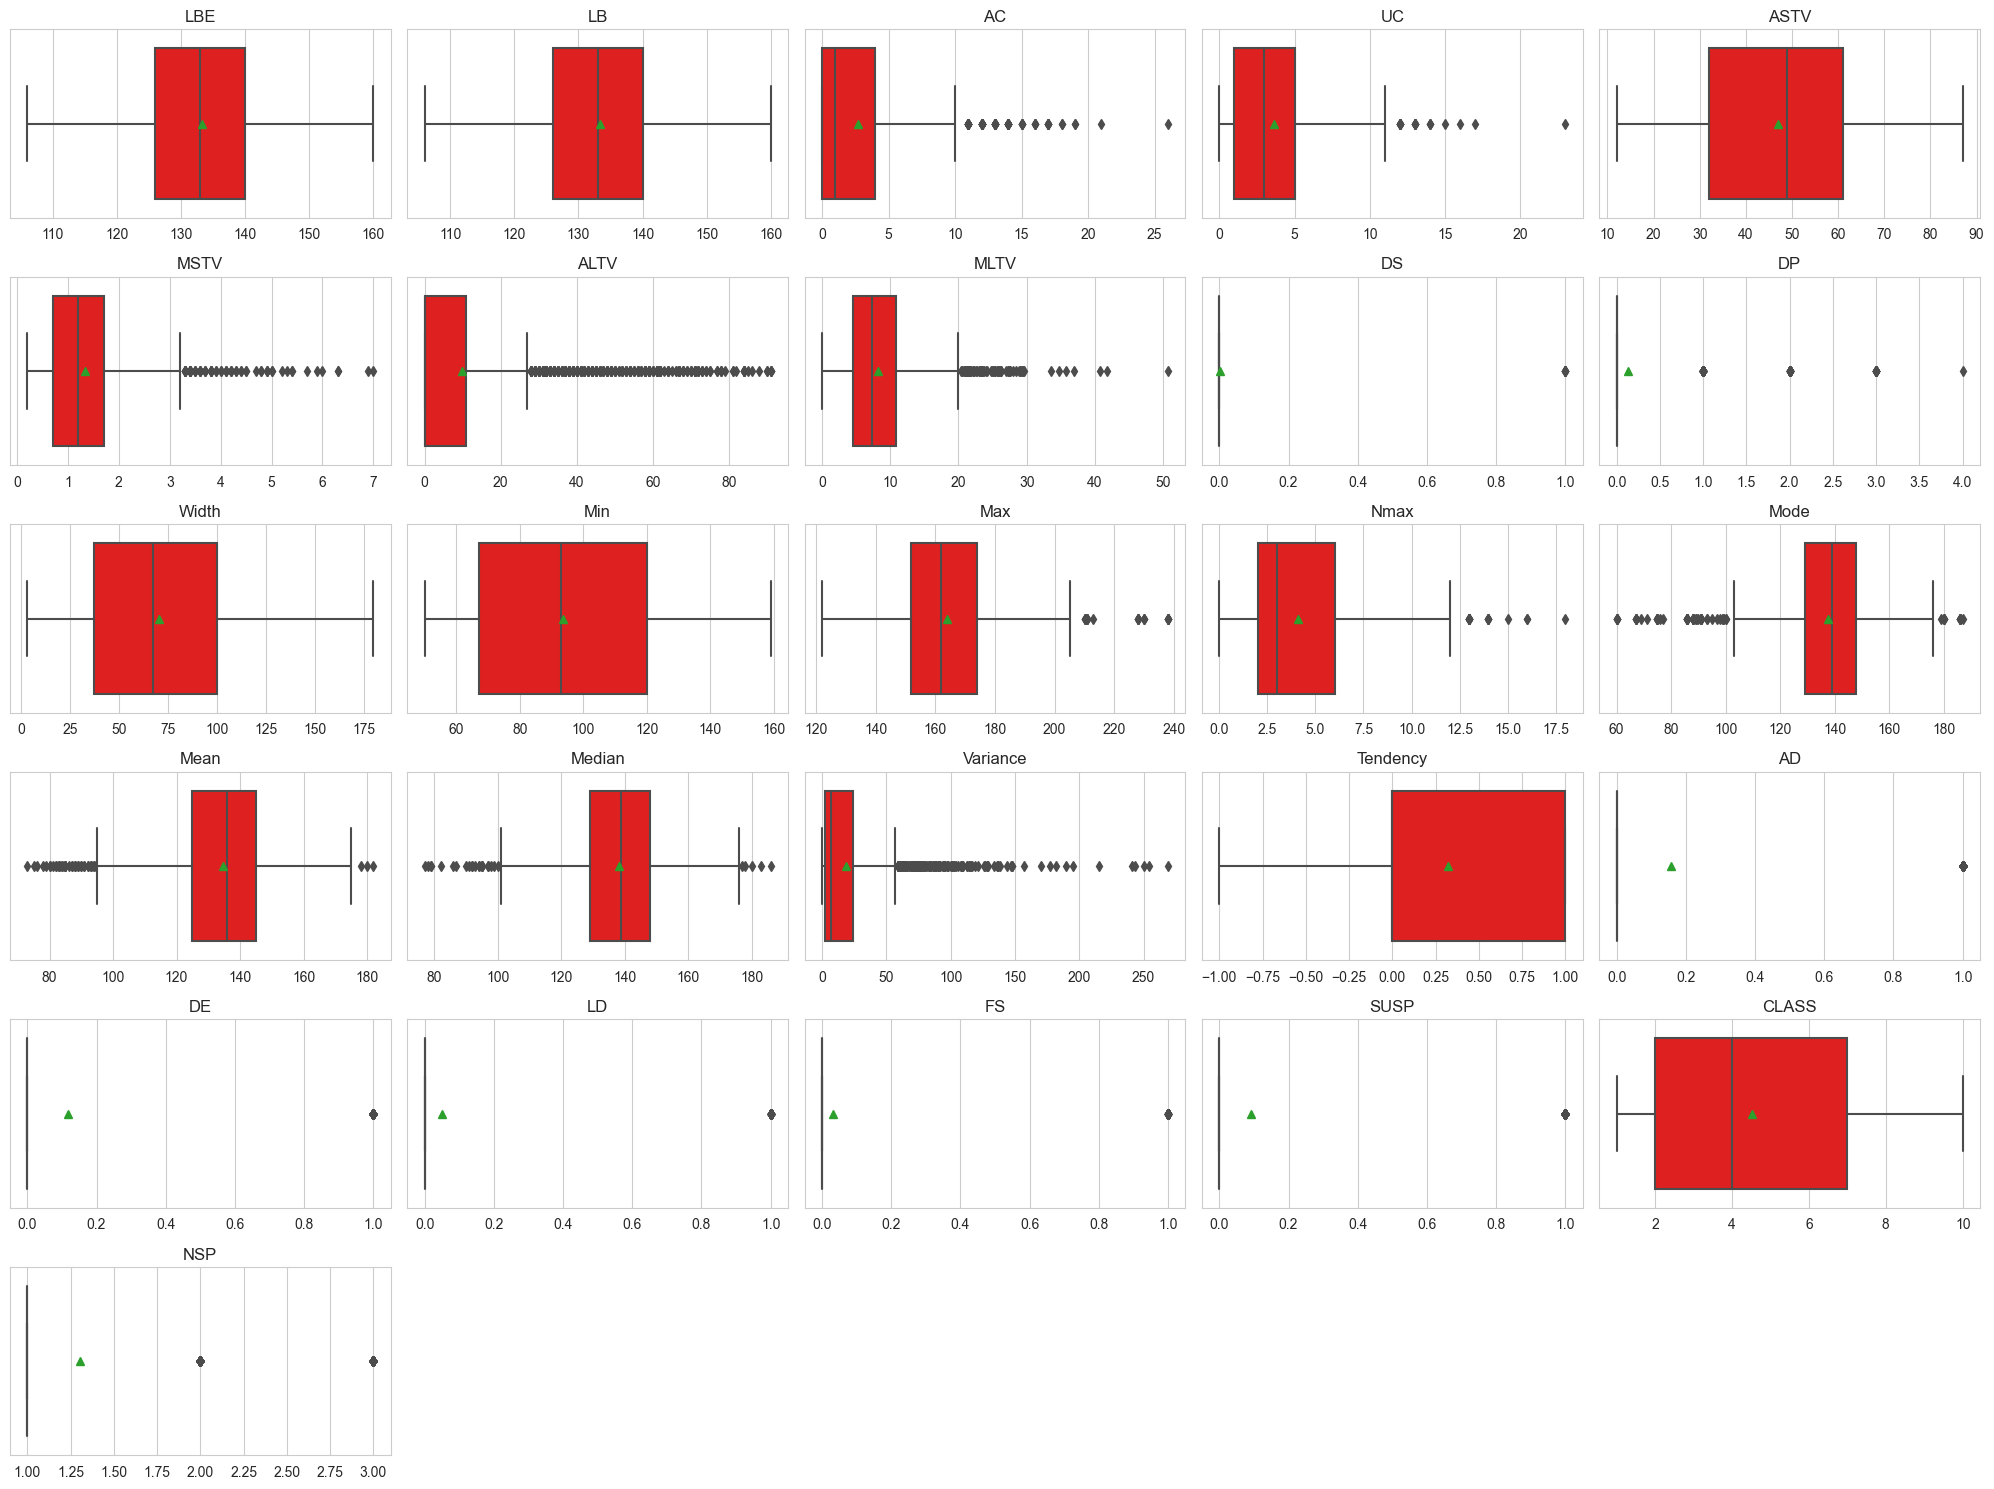

In [65]:
boxplot_all(data)

# Analisis de datos crudos
El análisis preliminar de los datos, observado a través de histogramas y gráficos de caja, revela la presencia de valores atípicos en las variables numéricas. Estos valores atípicos se distinguen por estar significativamente alejados de la media y caer fuera de la desviación estándar.

Además, se identifican variables que pueden ser tratadas como categóricas, como "Class", "SUSP", "NSP" y "Tendency".

Por otro lado, hay variables que muestran una distribución uniforme, como "LBE", "LB", "ASTV", "Width", "Max", "Mode", "Mean" y "Median". Para identificar y gestionar los valores atípicos en estas variables, se empleará la función de puntuación Z (z-score), la cual es una medida estadística que indica cuántas desviaciones estándar un dato se encuentra por encima o por debajo de la media del conjunto de datos.

Se establecerá un umbral de 3 desviaciones estándar con respecto a la media, lo que representa el 99.7% de los datos. De acuerdo con esta norma, se concluye que los datos que caen más allá de este umbral son atípicos, ya que difieren del 99.7% de los datos restantes. Este criterio nos permitirá identificar y potencialmente manejar estos valores atípicos en el análisis de los datos.

# Tratamiento de ouliers 

In [66]:
Columnas_numericas = ['LBE','LB','AC','UC','ASTV','MSTV','MLTV','Width','Min','Max','Nmax','Mean','Median','Variance']
outlierdata = data.copy()

In [67]:
data_filtered = otliers(outlierdata,Columnas_numericas)

LBE-Numero de outliers: 0
LB-Numero de outliers: 0
AC-Numero de outliers: 305
UC-Numero de outliers: 7
ASTV-Numero de outliers: 0
MSTV-Numero de outliers: 41
MLTV-Numero de outliers: 39
Width-Numero de outliers: 0
Min-Numero de outliers: 0
Max-Numero de outliers: 14
Nmax-Numero de outliers: 9
Mean-Numero de outliers: 17
Median-Numero de outliers: 7
Variance-Numero de outliers: 323


In [68]:
data.describe()

,LBE,LB,AC,UC,ASTV,MSTV,ALTV,MLTV,DS,DP,...,Median,Variance,Tendency,AD,DE,LD,FS,SUSP,CLASS,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,133.303857,2.722484,3.659925,46.990122,1.332785,9.84666,8.187629,0.003293,0.126058,...,138.090310,18.808090,0.320320,0.156162,0.118532,0.050329,0.032455,0.092662,4.509878,1.304327
std,9.840844,9.840844,3.560850,2.847094,17.192814,0.883241,18.39688,5.628247,0.057300,0.464361,...,14.466589,28.977636,0.610829,0.363094,0.323314,0.218675,0.177248,0.290027,3.026883,0.614377
min,106.000000,106.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,0.000000,0.000000,...,77.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,126.000000,126.000000,0.000000,1.000000,32.000000,0.700000,0.00000,4.600000,0.000000,0.000000,...,129.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,133.000000,133.000000,1.000000,3.000000,49.000000,1.200000,0.00000,7.400000,0.000000,0.000000,...,139.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
75%,140.000000,140.000000,4.000000,5.000000,61.000000,1.700000,11.00000,10.800000,0.000000,0.000000,...,148.000000,24.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
max,160.000000,160.000000,26.000000,23.000000,87.000000,7.000000,91.00000,50.700000,1.000000,4.000000,...,186.000000,269.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,3.000000


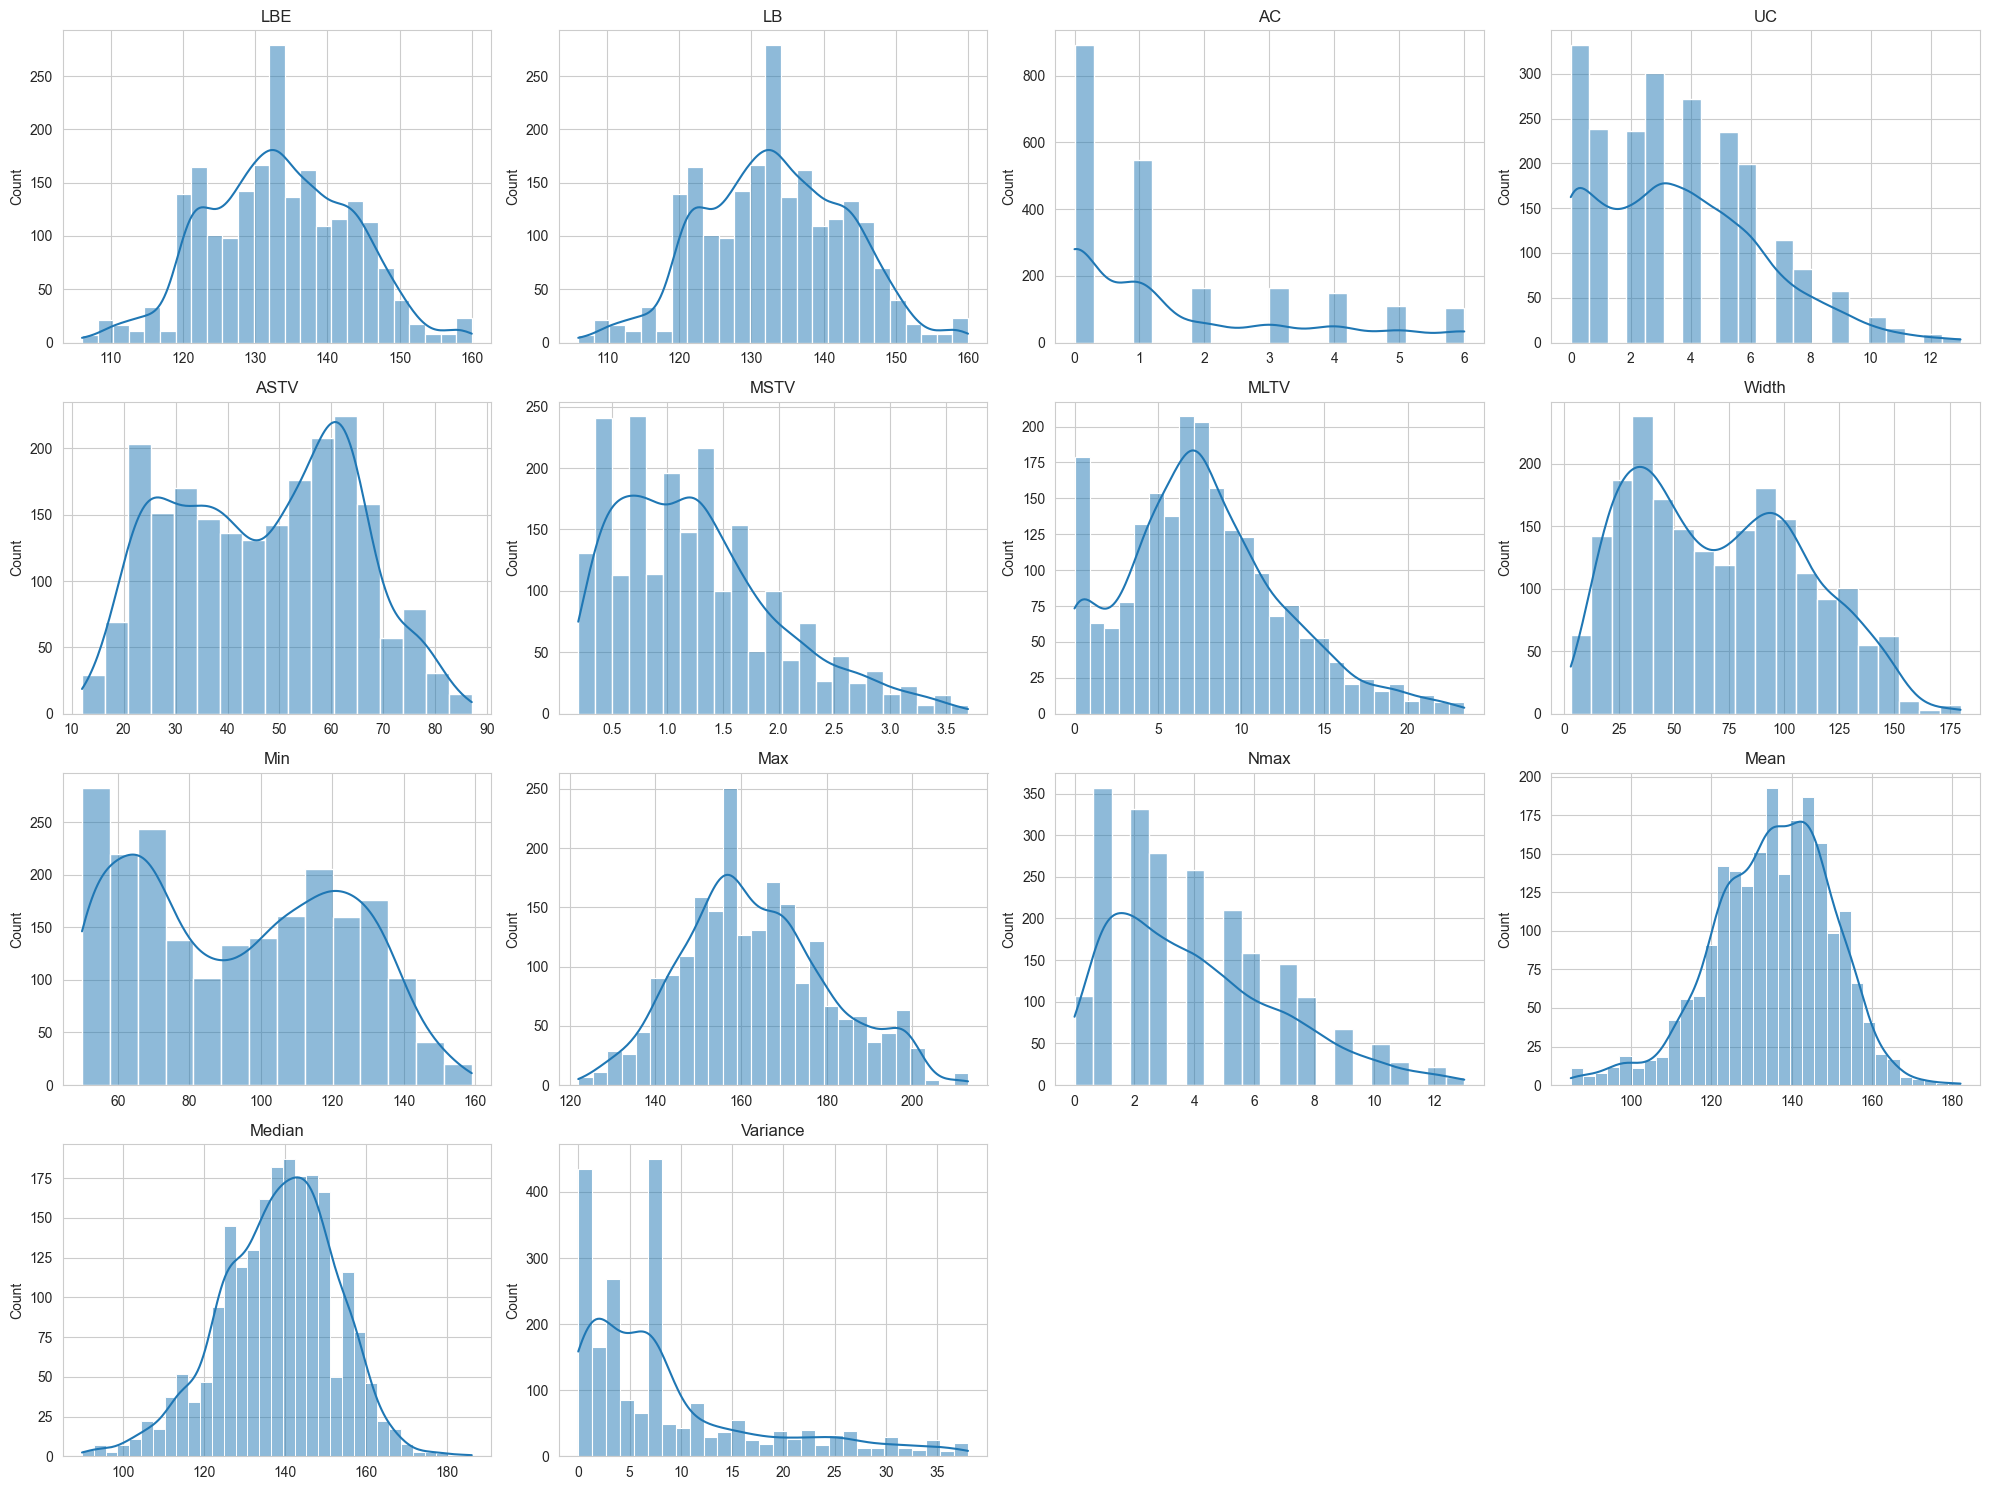

In [69]:
histogram_all(data_filtered[Columnas_numericas])

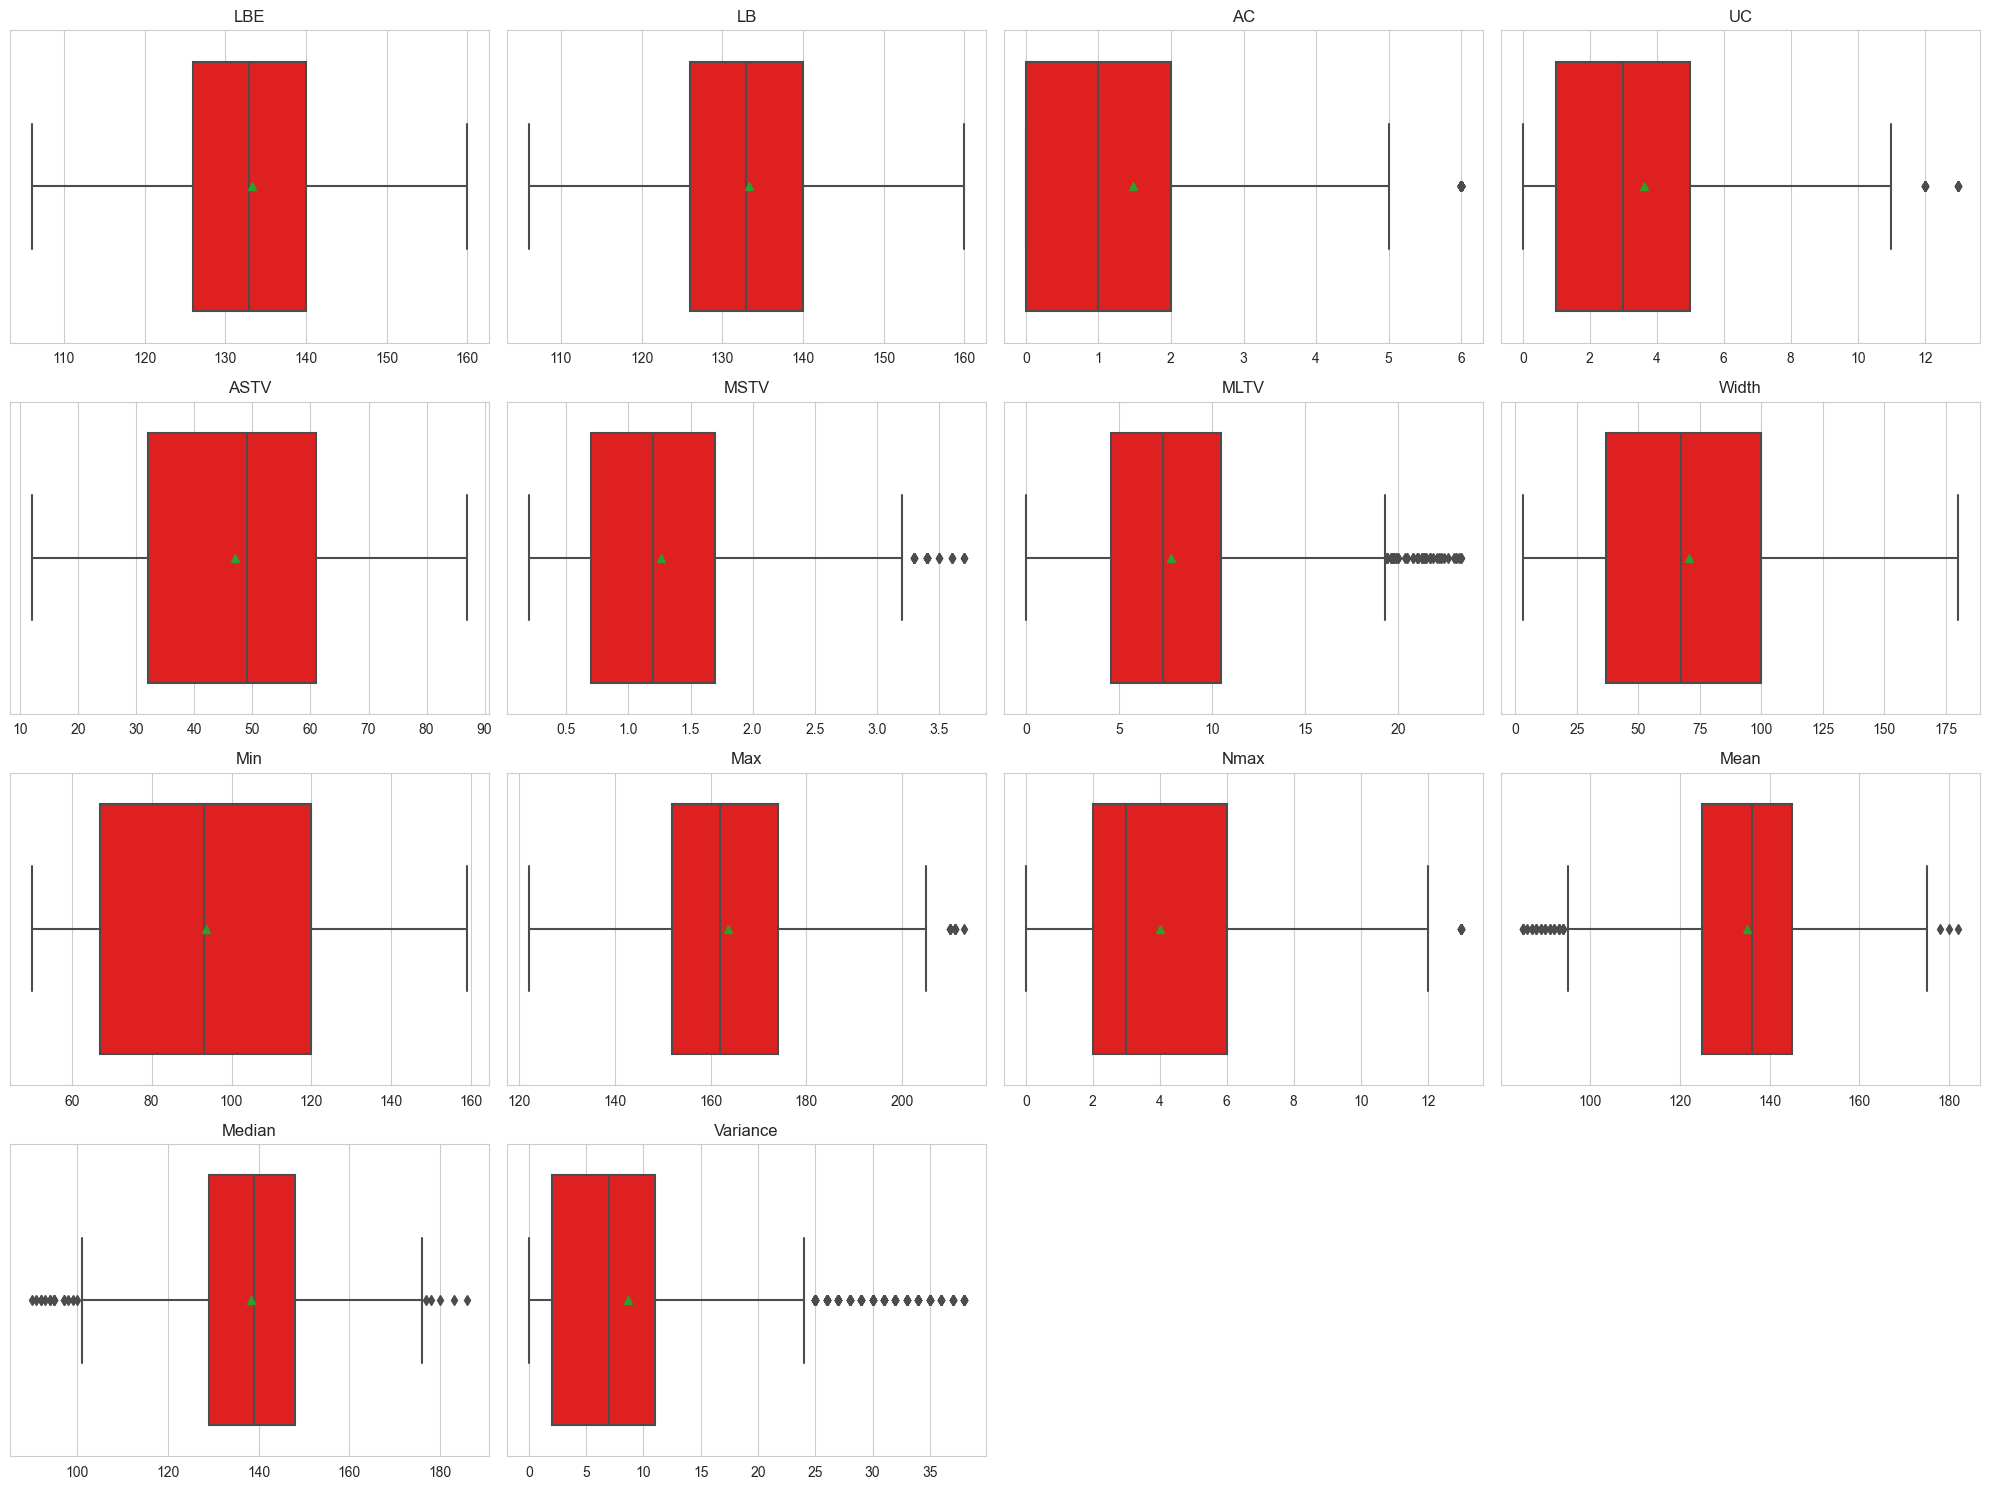

In [70]:
boxplot_all(data_filtered[Columnas_numericas])

In [71]:
# Escribir resultados de la eliminacion de outliers

# Identificacion de variables categoricas

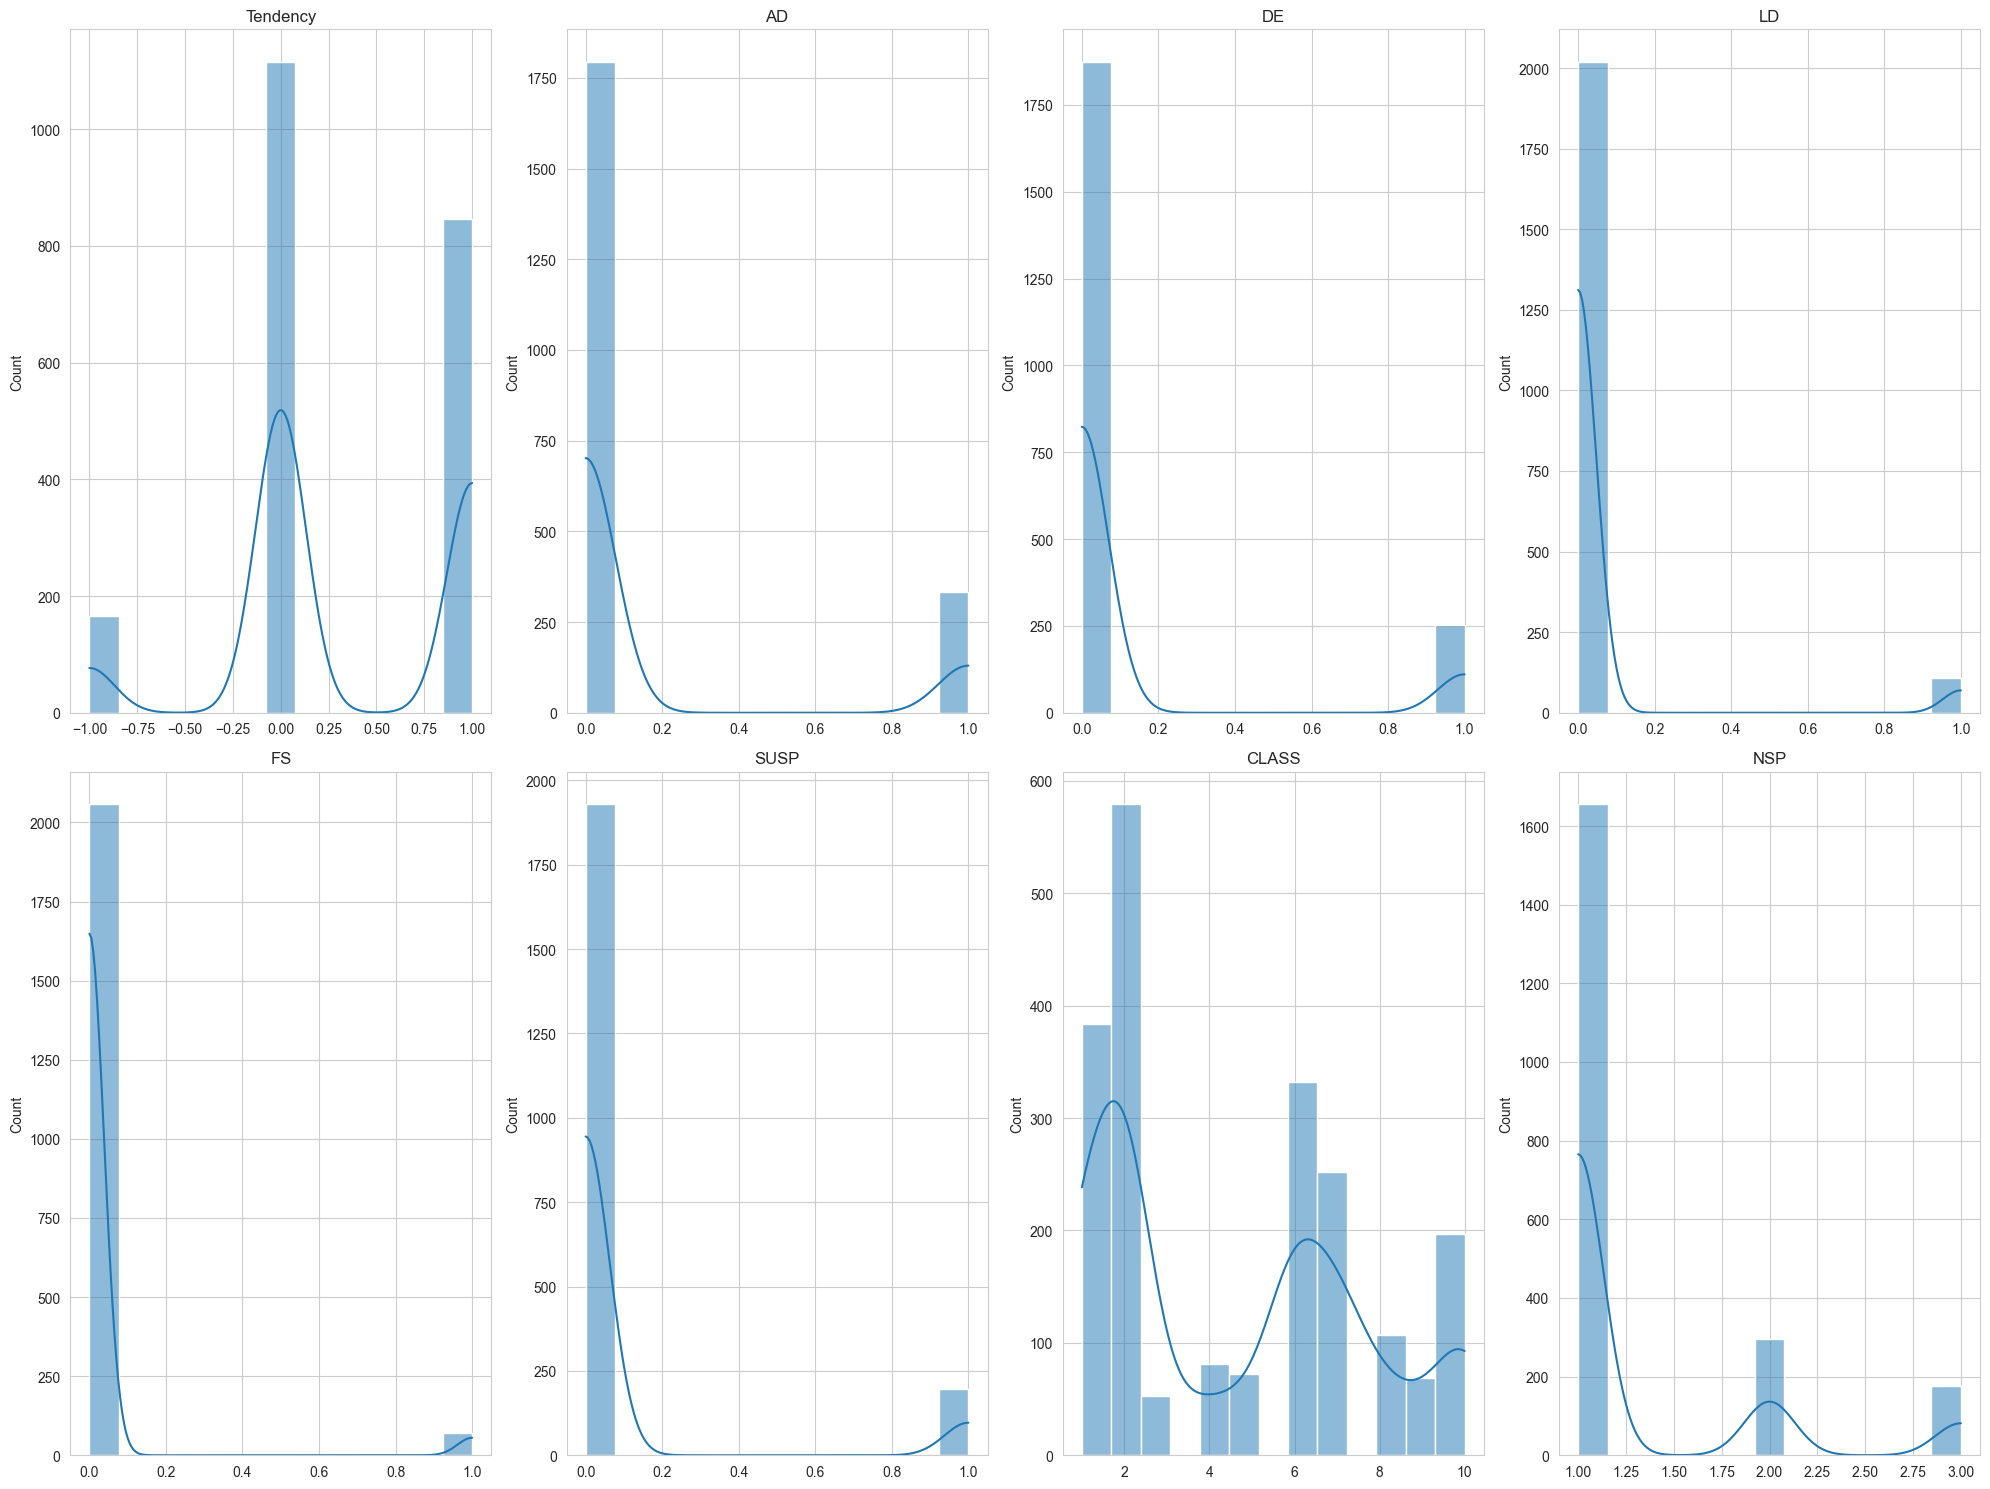

In [72]:
Columnas_Categoricas = ['Tendency','AD','DE','LD','FS','SUSP','CLASS','NSP']
data_filtered[Columnas_Categoricas] = data_filtered[Columnas_Categoricas].astype(int)
histogram_all(data_filtered[Columnas_Categoricas])

# Correlacion

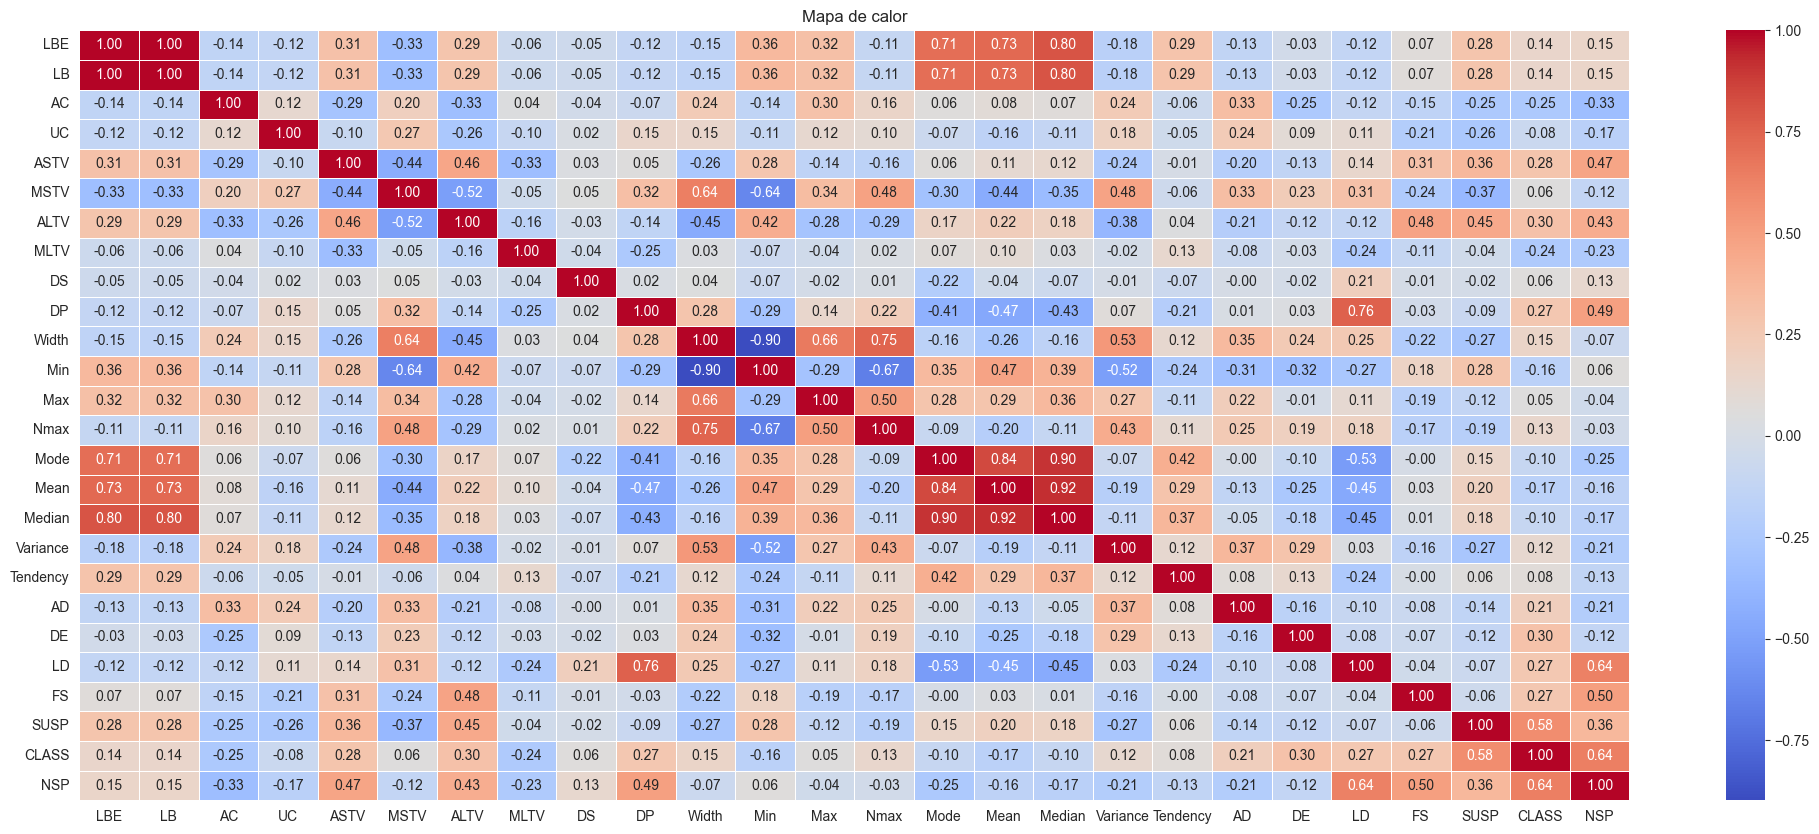

In [73]:
correlacion = data_filtered.corr()
plt.figure(figsize=(25,10))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt= '.2f',linewidths=.5)
plt.title('Mapa de calor')
plt.show()

# Modelo de agrupacion

In [74]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2126 entries, 0 to 2125
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LBE       2126 non-null   float64
 1   LB        2126 non-null   float64
 2   AC        2126 non-null   float64
 3   UC        2126 non-null   float64
 4   ASTV      2126 non-null   float64
 5   MSTV      2126 non-null   float64
 6   ALTV      2126 non-null   float64
 7   MLTV      2126 non-null   float64
 8   DS        2126 non-null   float64
 9   DP        2126 non-null   float64
 10  Width     2126 non-null   float64
 11  Min       2126 non-null   float64
 12  Max       2126 non-null   float64
 13  Nmax      2126 non-null   float64
 14  Mode      2126 non-null   float64
 15  Mean      2126 non-null   float64
 16  Median    2126 non-null   float64
 17  Variance  2126 non-null   float64
 18  Tendency  2126 non-null   int32  
 19  AD        2126 non-null   int32  
 20  DE        2126 non-null   int32  
 

In [75]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0,1))
data_norm = scaler.fit_transform(data_filtered)
data_norm

array([[0.25925926, 0.25925926, 0.        , ..., 0.        , 0.88888889,
        0.5       ],
       [0.48148148, 0.48148148, 0.66666667, ..., 0.        , 0.55555556,
        0.        ],
       [0.5       , 0.5       , 0.33333333, ..., 0.        , 0.55555556,
        0.        ],
       ...,
       [0.62962963, 0.62962963, 0.16666667, ..., 0.        , 0.44444444,
        0.5       ],
       [0.62962963, 0.62962963, 0.16666667, ..., 0.        , 0.44444444,
        0.5       ],
       [0.66666667, 0.66666667, 0.16666667, ..., 0.        , 0.        ,
        0.        ]])

In [76]:
X=data_filtered[['LBE', 'LB', 'AC', 'UC','DS', 'DP']]
Y=data_filtered[["NSP"]]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0,1))
X = scaler.fit_transform(X)

In [77]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

In [78]:
from sklearn.svm import SVC

svm_clf=SVC(kernel="poly",degree=6,coef0=5,gamma=0.1)
svm_clf=svm_clf.fit(X_train,y_train)
y_pred=svm_clf.predict(X_test)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [79]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
print(confusion_matrix(y_test,y_pred))

[[463  30   3]
 [ 34  64   3]
 [ 14  10  17]]


In [80]:
f1_score(y_test,y_pred,average='weighted')

0.8478807863553639

In [81]:
accuracy_score(y_test,y_pred)

0.8526645768025078

In [82]:
precision_score(y_test,y_pred,average='weighted')

0.8493216237255177

In [83]:
recall_score(y_test,y_pred,average="weighted")

0.8526645768025078

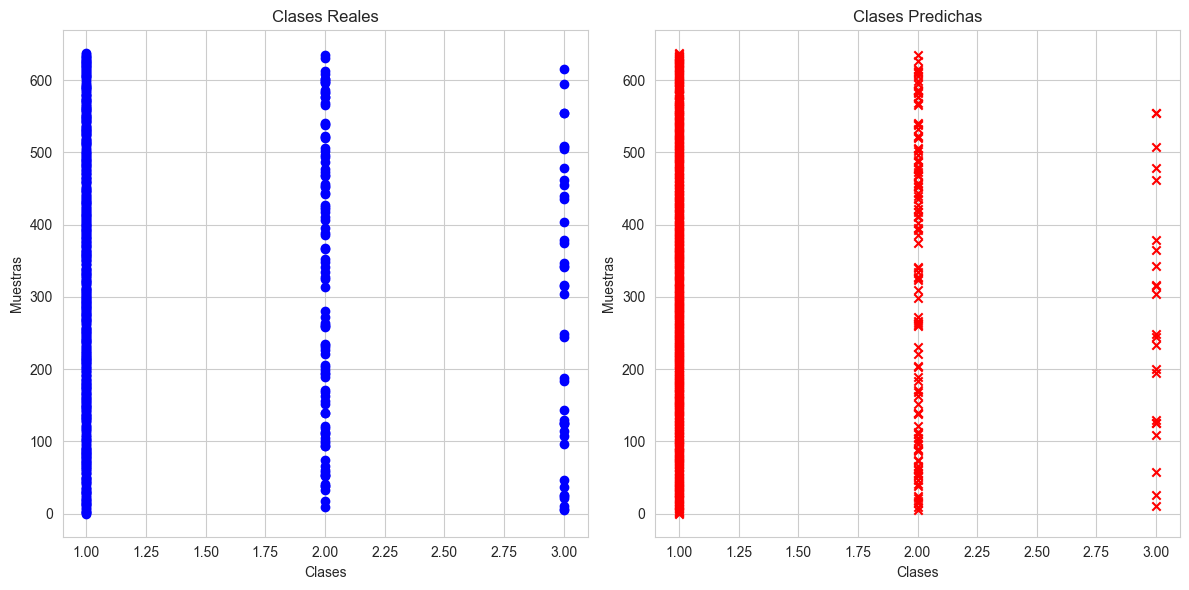

In [84]:
import matplotlib.pyplot as plt

# Obtener el número total de muestras
n_samples = len(y_test)

# Crear una figura y subtramas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Subtrama 1: Clases reales
ax1.scatter(y_test, range(n_samples), color='blue', label='Clases reales')
ax1.set_xlabel('Clases')
ax1.set_ylabel('Muestras')
ax1.set_title('Clases Reales')

# Subtrama 2: Clases predichas
ax2.scatter(y_pred, range(n_samples), color='red', marker='x', label='Clases predichas')
ax2.set_xlabel('Clases')
ax2.set_ylabel('Muestras')
ax2.set_title('Clases Predichas')

# Ajustar diseño y mostrar el gráfico
plt.tight_layout()
plt.show()